# Mortgage-Backed Securities Analysis: Cash flow and duration modeling

This IPython Notebook provides a comprehensive analysis of Mortgage-Backed Securities (MBS), focusing on cash flow modeling, prepayment risks, and duration. It is based on a quantitative case study that explores how interest rate movements impact borrower behavior and security valuation.

### Background and Motivation

The Mortgage-Backed Securities (MBS) market is a key segment of the fixed-income universe where pools of residential or commercial mortgages are bundled and sold to investors. These securities provide periodic cash flows derived from homeowners' mortgage payments—including interest, scheduled principal, and prepayments.

Investors in MBS face three primary risks:

1. Interest Rate Risk: Changes in market rates affect the discounting of future cash flows.

2. Prepayment Risk: When rates drop, homeowners refinance, returning principal to investors early when reinvestment opportunities have lower yields.

3. Extension Risk: When rates rise, prepayments slow down, locking investors into lower-yielding assets for longer.

### The Problem: The Complexity of "The Mortgage"

Unlike a standard corporate bond, where cash flows are fixed and predictable, a MBS is a "living" financial instrument. Its value is dictated by the behavior of thousands of individual homeowners. When interest rates drop, homeowners refinance, returning principal to investors at the worst possible time (prepayment risk). When rates rise, they stop prepaying, locking investors into low-yield assets for longer than expected (extension risk).

### Project Goals

The objective of this project is to build a quantitative model to simulate these dynamics and quantify the inherent risks of an MBS pool. Using a $100M pool with a 5% Weighted Average Coupon (WAC), this study achieves the following:

- **Algorithmic Cash Flow Modeling**: Develop a modular engine to simulate monthly interest, scheduled principal, and prepayment cash flows.

- **Dynamic Prepayment Modeling (The S-Curve)**: Implement a non-linear S-Curve model to calculate the Conditional Prepayment Rate (CPR) based on interest rate refinancing incentives.

- **Path-Dependent Analysis**: Simulate the "time-to-payoff" under varying interest rate environments, demonstrating how a 30-year maturity can compress to just 6.5 years or extend to nearly 27 years depending on market shifts.

- **Quantifying Negative Convexity**: Measure the sensitivity of the security's price to interest rate "bumps" to visualize the asymmetric risk profile (Negative Convexity) that defines the MBS market.

### Why This Matters

This project demonstrates the ability to translate complex financial theory into functional, object-oriented Python code. By the end of this notebook, we will visualize the "loss-loss" situation for MBS investors, proving why sophisticated duration hedging is required to manage these unique assets.

Let us begin!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mbs_model import PrepaymentModel

### MBS Cash Flow Modeling with simplified prepayment assumptions

As established, a MBS is a complex instrument whose value is dictated by the collective behavior of thousands of individual borrowers. To accurately value these securities, we must model prepayment behavior, which introduces significant volatility to cash flow timing. Thus, let us first simulate the cash flows for the first 24 months of a simplified MBS pool under a deterministic interest rate path. 

1. The MBS Pool Parameters
   
We assume a standard residential mortgage pool with the following characteristics :

- **Original MBS balance:** $ 100 million
- **WAC (Weighted Average Coupon):** 5% annually
- **WAM (Weighted Average Maturity):** 360 months
- **Monthly Amortization:** Level payment (fully amortizing)
  
The key idea going ahead is to model the dependence of MBS cash flows on prepayment behavior which in turn is incentivized by the decreasing future interest rates. On the other hand, increasing interest rates in the future usually discourages prepayment. Thus, the interest rate paths are crucial in estimating the prepayment behavior. However, in real world markets, these interest rates are governed by various unpredictable factors and is usually better captured through stochastic modeling. To achieve a simple understanding, it is convenient to assume the interest path to be deterministic and create a prepayment model with simplified assumptions. 

2. The Deterministic Interest Rate Path

To observe how cash flows react to market changes, we assume the following interest rate environment :

- **Months 1–12:** A flat market rate of 5.0% (Annual) 
- **Months 13–24:** Market rates drop to 4.0%

3. The S-Curve Prepayment Model

The "heart" of this analysis is the S-Curve Prepayment Model, which maps the financial incentive for a homeowner to refinance to the Conditional Prepayment Rate (CPR). The incentive is defined as the difference between the pool's WAC and the current market rate (Incentive = WAC−Rate)

- CPR = 0% if incentive < 0%
- CPR = 5% if incentive = 0%
- CPR increases linearly to 30% when incentive = 2%
- CPR stays constant at 30% if incentive beyong 2%

Let us now simulate the MBS cashflow modeling under the above circumstances. 

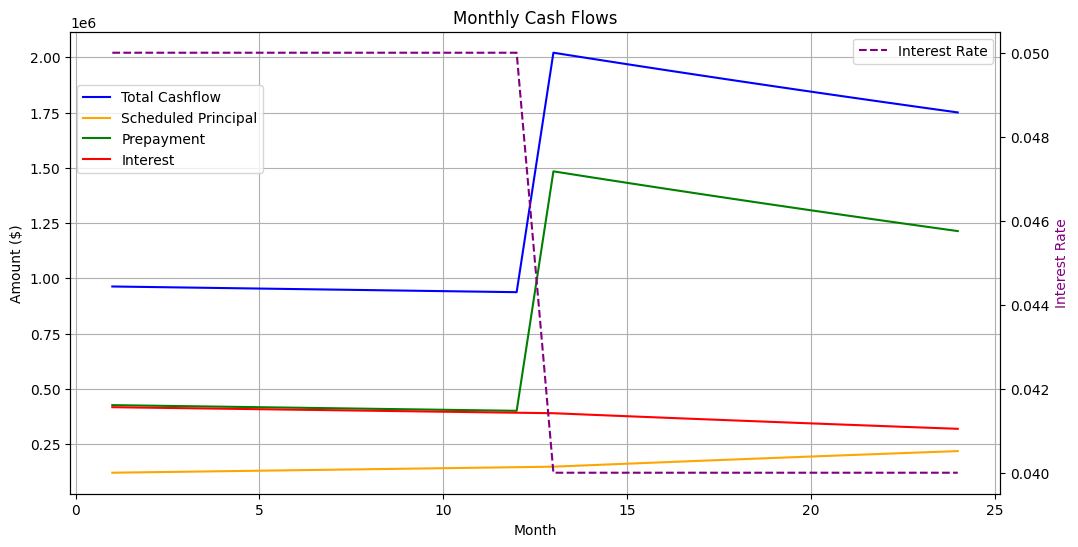

In [2]:
# Replicating the Case Study scenario
rates_path = [0.05]*12 + [0.04]*12
model = PrepaymentModel(mbs_amount=100000000, wac=0.05, wam=360, market_rates=rates_path,
                 min_cpr=0.0, base_cpr = 0.05, max_cpr=0.3, incentive_cutoff=0.02)

cashflow_df = model.simulate_cashflow(num_months=24)

# Visualization
fig,ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax.plot(cashflow_df['Month'], cashflow_df['Total Cashflow'], color='blue', label='Total Cashflow')
ax.plot(cashflow_df['Month'], cashflow_df['Scheduled Principal'], color='orange', label='Scheduled Principal')
ax.plot(cashflow_df['Month'], cashflow_df['Prepayment'], color='green', label='Prepayment')
ax.plot(cashflow_df['Month'], cashflow_df['Interest'], color='red', label='Interest')
ax2.plot(cashflow_df['Month'], cashflow_df['Interest Rate'], color='purple', label='Interest Rate', linestyle='--')
ax2.set_ylabel('Interest Rate', color='purple')
plt.title('Monthly Cash Flows')
ax.set_xlabel('Month')
ax.set_ylabel('Amount ($)')
# add grid lines 
ax.grid(True)
# find the best location for legend
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

ax2.legend(loc='upper right')

plt.show()

### Takeaways:

From the figure above, it is apparent that a drop in the interest rates results in a clear sharp rise in the
amount of prepayments and as a result a sharp rise in the total cashflow to the MBS pool. The investors of MBS pool receive a large chunk of their invested principal. The drop of interest rates resulting in increased prepayments is termed as the **prepayment risk**. This is not a good sign for the investors as they receive a chunk of their principal at a time when other avenues have lower interest rates and thus lowering returns on investments. From the definition of CPR, we can also gauge the behavior when the interest rates soar. In our model, this would result in a negative incentive to prepay the model. The payments to the MBS pool will constitute usual interest payments and the scheduled principal payments with no prepayments. Thus, the MBS investors would receive returns lesser than that of current market interest rates again lowering returns on investments. This is termed as the **extension risk**.

### Scenario Analysis: Quantifying the Variable Life of an MBS

Our previous analysis of monthly cash flow components demonstrated a critical volatility in principal returns: as market interest rates dropped, borrower refinancing incentives triggered a sharp spike in prepayments. This observation leads to a fundamental realization in mortgage modeling—the Weighted Average Maturity (WAM) of 360 months is a nominal figure, not a fixed schedule.

In reality, the actual "life" or payoff duration of an MBS is a dynamic variable dictated by the interest rate environment. To quantify this sensitivity, we will now simulate the pool’s remaining balance over time across three distinct macroeconomic paths:

- **Lower Rate Environment (3%):** Testing the limits of prepayment acceleration.

- **Static Environment (5%):** Establishing a baseline for turnover-driven prepayments.

- **Rising Rate Environment (6%):** Measuring the impact of "burnt-out" refinancing incentives and loan extension.

By finding the exact month where the remaining balance reaches zero, we can visualize the dramatic contraction and expansion of the security's lifespan.

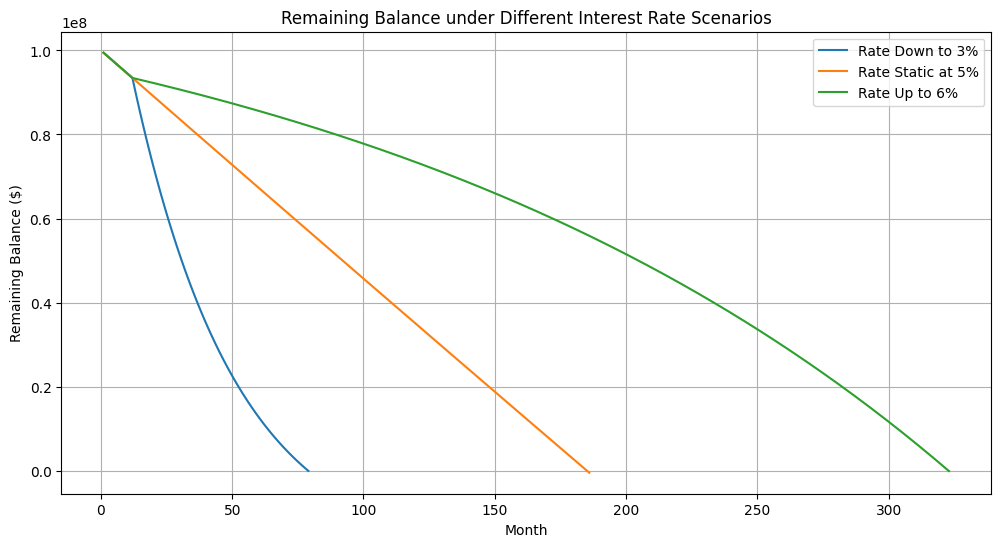

In [3]:
rates_path_lower = [0.05]*12 + [0.03]*12
model_lower = PrepaymentModel(mbs_amount=100000000, wac=0.05, wam=360, market_rates=rates_path_lower,
                 min_cpr=0.0, base_cpr = 0.05, max_cpr=0.3, incentive_cutoff=0.02)
cashflow_lower = model_lower.simulate_cashflow()

rates_path_static = [0.05]*12 + [0.05]*12
model_static = PrepaymentModel(mbs_amount=100000000, wac=0.05, wam=360, market_rates=rates_path_static,
                 min_cpr=0.0, base_cpr = 0.05, max_cpr=0.3, incentive_cutoff=0.02)
cashflow_static = model_static.simulate_cashflow()

rates_path_rising = [0.05]*12 + [0.06]*12
model_rising = PrepaymentModel(mbs_amount=100000000, wac=0.05, wam=360, market_rates=rates_path_rising,
                 min_cpr=0.0, base_cpr = 0.05, max_cpr=0.3, incentive_cutoff=0.02)
cashflow_rising = model_rising.simulate_cashflow()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cashflow_lower['Month'], cashflow_lower['Remaining Balance'], label='Rate Down to 3%')
ax.plot(cashflow_static['Month'], cashflow_static['Remaining Balance'], label='Rate Static at 5%')
ax.plot(cashflow_rising['Month'], cashflow_rising['Remaining Balance'], label='Rate Up to 6%')
ax.set_title('Remaining Balance under Different Interest Rate Scenarios')
ax.set_xlabel('Month')
ax.set_ylabel('Remaining Balance ($)')
ax.legend()
plt.grid(True)
plt.show()

### Takeaways:

From the figure above, we observe that the duration when the MBS is paid off varies across the provided scenarios. Namely, scenario 1, where the interest rates are down, has the fastest pay-off time (79 months) followed by scenario 2 (186 months), where the interest rates are static. Scenario 3 (323 months) results in the slowest pay-off time due to negative incentive to prepay the loan. This agrees with our previous observation that lower interest rates creates an incentive for borrowers to pay off their mortgage quicker. In the static case, even though there is no incentive to pay early, our model assumed a base prepayment rate of 5% which clearly speeds up the repayment time compared to a model with no prepayment. In the last case, there is a negative incentive to prepay the loan from the second year which ultimately leads to a longer duration.

To summarize our analysis so far, lower(higher) interest rates encourages (discourages) prepayments. We can also reason why an individual would opt for prepaying their loan. Suppose, the market interest rates have lowered since the origination of the mortgage. They can opt to refinance a new mortgage to pay their outstanding principal
at this lower market rate and in turn would land a lower monthly payments for the same duration. 

**From a standpoint of present value (PV):** The PV of the mortgage in this scenario wouldbe higher than the principal outstanding and thus individuals who borrowed the mortgage, gains in the present value sense by prepaying the outstanding principal. If the interest rates soar, the PV of the mortgage is lower than the principal outstanding and thus borrowers loses money in the present value by prepaying the loan.

### Advanced Risk Metrics: The Phenomenon of Negative Convexity

While traditional fixed-income securities, such as U.S. Treasuries, typically exhibit **positive convexity**—where the price increases at an accelerating rate as yields fall—MBS present a more complex and asymmetric risk profile known as **Negative Convexity**.

This unique characteristic is a direct result of the **embedded call option** held by the homeowner. As we observed in our duration analysis, a decrease in interest rates triggers a wave of prepayments. For the investor, this means that just as the security’s price should be rising significantly due to lower discount rates, the underlying principal is returned early, effectively "capping" the price appreciation. Conversely, when rates rise, prepayments dry up and the security’s duration extends, causing the price to fall more steeply than a comparable non-callable bond.

This creates what is often described as a **"loss-loss" situation** for MBS investors: they face reinvestment risk when rates are low and extension risk when rates are high.

In this final section, we will quantify this asymmetry by "bumping" our interest rate environment by $\pm 25$ and $\pm 50$  basis points . By calculating the resulting Present Values (PVs) and plotting them against the interest rate deltas, we can visualize the negative convexity that defines the MBS market and necessitates sophisticated hedging strategies.

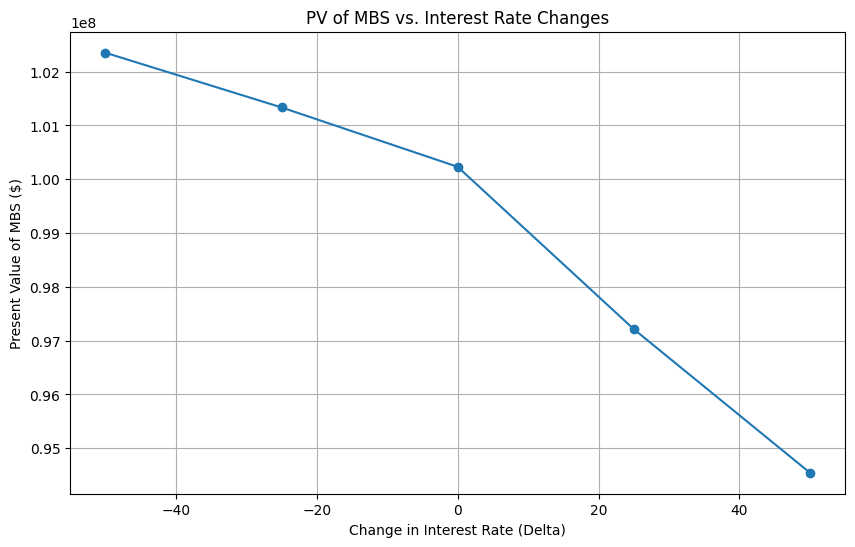

In [4]:
# find the present value of cash flows at the same discount rate as the static interest rate scenario
def find_pv(cashflow_df, monthly_discount_rate):
    """
    Info: Find the present value of cash flows based on a discount rate
    Out: Returns the present value
    """
    cashflows = cashflow_df['Total Cashflow'].values
    months = cashflow_df['Month'].values
    pv_cashflows = cashflows / (1 + monthly_discount_rate) ** months
    total_pv = np.sum(pv_cashflows)
    return total_pv

delta_list = [-0.005, -0.0025, 0.0, 0.0025, 0.005]
bumps = [-50, -25, 0, 25, 50]
PV_list = []
for delta in delta_list:
    bumped_rate = 0.05 + delta
    rates_path = [bumped_rate]*360
    model = PrepaymentModel(mbs_amount=100000000, wac=0.05, wam=360, market_rates=rates_path,
                 min_cpr=0.0, base_cpr = 0.05, max_cpr=0.3, incentive_cutoff=0.02)
    cashflow_df = model.simulate_cashflow()
    pv_temp = find_pv(cashflow_df, bumped_rate/12)
    PV_list.append(pv_temp)

plt.figure(figsize=(10,6))
plt.plot(bumps, PV_list, marker='o')
plt.title('PV of MBS vs. Interest Rate Changes')
plt.xlabel('Change in Interest Rate (Delta)')
plt.ylabel('Present Value of MBS ($)')
plt.grid(True)
plt.show()

### **Quantitative Benchmark: MBS vs. The Standard Bond**
To truly isolate the impact of **Negative Convexity**, we must compare the MBS portfolio against a benchmark that shares the same cash flow structure but lacks the prepayment option. By simulating a **Synthetic Standard Bond** (where prepayments are fixed at 0%), we can visualize the "Option Cost" borne by the investor. This comparison allows us to quantify:

1. **Reinvestment Risk:** The price appreciation lost when homeowners refinance in a falling-rate environment.
2. **Extension Risk:** The accelerated price depreciation when rates rise and the security's duration "stretches."

The following analysis "shocks" both the MBS and the Standard Bond by $\pm 25$ and $\pm 50$  basis points to map out their respective price-yield curvatures.

In [5]:
# Calculate the 'Standard Bond' (MBS with 0 Prepayments)
standard_pv_list = []

for delta in delta_list:
    bumped_rate = 0.05 + delta
    model_no_prepay = PrepaymentModel(
        mbs_amount=100000000, wac=0.05, wam=360, 
        market_rates=[bumped_rate]*360,
        min_cpr=0.0, base_cpr=0.0, max_cpr=0.0  # Prepayments set to zero
    )
    cf_no_prepay = model_no_prepay.simulate_cashflow()
    pv_no_prepay = find_pv(cf_no_prepay, bumped_rate/12)
    standard_pv_list.append(pv_no_prepay)

mbs_base_pv = PV_list[2]
std_base_pv = standard_pv_list[2]

mbs_pct_change = [(pv / mbs_base_pv - 1) * 100 for pv in PV_list]
std_pct_change = [(pv / std_base_pv - 1) * 100 for pv in standard_pv_list]

df_results = pd.DataFrame({
    'Rate Shift (bps)': bumps,
    'MBS Price Change (%)': mbs_pct_change,
    'Standard Bond Change (%)': std_pct_change
})

df_results['Convexity Gap (%)'] = df_results['MBS Price Change (%)'] - df_results['Standard Bond Change (%)']

print("Risk Metric Summary:")
display(df_results.style.format("{:.2f}%").background_gradient(cmap='RdYlGn', subset=['Convexity Gap (%)']))

Risk Metric Summary:


,Rate Shift (bps),MBS Price Change (%),Standard Bond Change (%),Convexity Gap (%)
0,-50.00%,2.12%,5.95%,-3.83%
1,-25.00%,1.10%,2.91%,-1.81%
2,0.00%,0.00%,0.00%,0.00%
3,25.00%,-3.01%,-2.79%,-0.22%
4,50.00%,-5.67%,-5.45%,-0.22%


The tabular results demonstrate a "Negative Convexity" of -3.83% at the -50bps shock. This confirms that the embedded prepayment option acts as a short volatility position. For a portfolio manager, this indicates that a standard $1^{st}$-order (Duration) hedge would be under-hedged in a rallying market and over-hedged in a sell-off, highlighting the necessity of Gamma (Convexity) management.

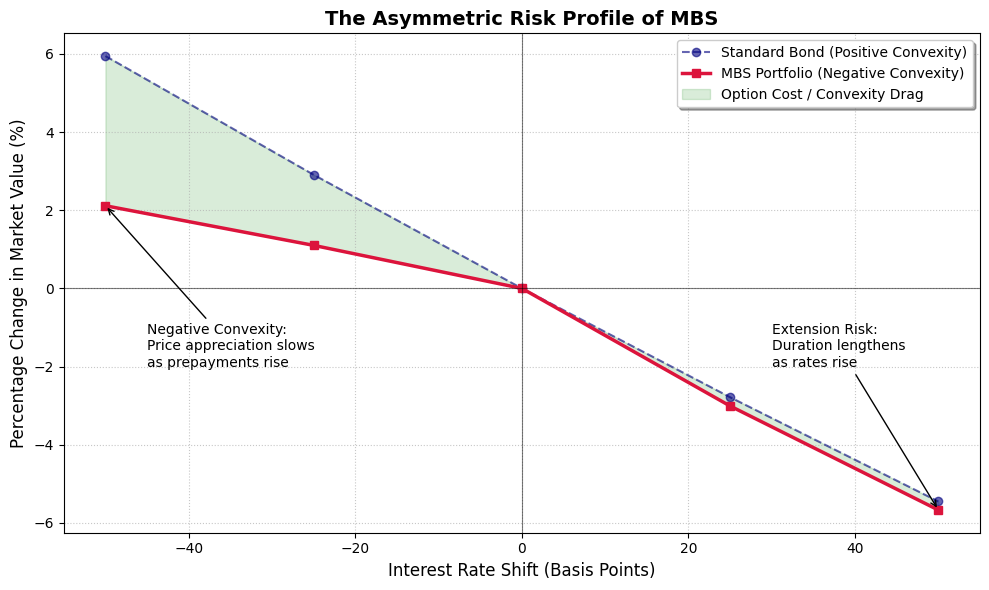

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(bumps, std_pct_change, label='Standard Bond (Positive Convexity)', 
         marker='o', linestyle='--', color='navy', alpha=0.6)
plt.plot(bumps, mbs_pct_change, label='MBS Portfolio (Negative Convexity)', 
         marker='s', linestyle='-', color='crimson', linewidth=2.5)

plt.axhline(0, color='black', linewidth=0.8, alpha=0.5)
plt.axvline(0, color='black', linewidth=0.8, alpha=0.5)

# Annotations to explain the chart
plt.annotate('Negative Convexity:\nPrice appreciation slows\nas prepayments rise', 
             xy=(-50, mbs_pct_change[0]), xytext=(-45, -2.0),
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate('Extension Risk:\nDuration lengthens\nas rates rise', 
             xy=(50, mbs_pct_change[-1]), xytext=(30, -2.0),
             arrowprops=dict(arrowstyle='->', color='black'))
plt.fill_between(bumps, mbs_pct_change, std_pct_change, 
                 color='green', alpha=0.15, label='Option Cost / Convexity Drag')
plt.title('The Asymmetric Risk Profile of MBS', fontsize=14, fontweight='bold')
plt.xlabel('Interest Rate Shift (Basis Points)', fontsize=12)
plt.ylabel('Percentage Change in Market Value (%)', fontsize=12)
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

### Interpretation: The Convexity Gap

This visualization reveals the structural disadvantage of the MBS investor compared to a standard fixed-income investor. While both securities respond to interest rate changes, their **second-order sensitivity (Gamma)** is fundamentally different.

#### The Left Tail: Prepayment "Drag" (Rates -50bps)

In a rallying market where rates fall, the Standard Bond exhibits **Positive Convexity**, where the price increases at an accelerating rate. However, the MBS curve flattens.

* **The Interpretation:** This is the visual signature of the **embedded call option**. As yields drop, homeowners refinance, and the principal is returned to the investor exactly when reinvestment rates are at their lowest. This effectively "caps" the upside of the MBS.

#### The Right Tail: Extension Risk (Rates +50bps)

When rates rise, the MBS price falls more steeply than the Standard Bond.

* **The Interpretation:** As rates rise, the homeowner's incentive to prepay disappears. The security's duration "stretches", making the MBS more sensitive to further rate hikes.

The area between the two curves represents the **Option Cost** paid by the MBS investor. By being 'short' this convexity, the investor underperforms a standard bond in both extreme rallying and extreme sell-off scenarios. This confirms that an MBS is a **short-volatility** instrument: it performs best when rates remain range-bound (low volatility) and underperforms when interest rate volatility spikes.

# Conclusion

Through this comprehensive analysis, we have moved from the theoretical underpinnings of mortgage behavior to a functional quantitative model capable of isolating the most elusive risk in the fixed-income markets: **Negative Convexity.**

### 1. Modeling the Human Element

At the core of this notebook is the recognition that an MBS is not just a bond, but a collection of embedded options held by homeowners. By implementing a path-dependent **Prepayment S-Curve**, we successfully modeled the non-linear relationship between interest rates and cash flow velocity. We observed that as rates drop, the homeowner’s incentive to refinance creates a surge in prepayments that fundamentally alters the security's lifecycle.

### 2. The Discovery of the "Convexity Gap"

The defining achievement of this study was the side-by-side comparison of the MBS against a standard bond benchmark. Our sensitivity analysis across $\pm 50$ bps shocks revealed a striking divergence:

* **The Opportunity Cost:** In a rallying market, the MBS exhibits a "price cap," where the investor loses significant upside to the benchmark.
* **The Downside Acceleration:** In a bear market, the MBS price falls faster and harder as the duration "stretches," leaving the investor with a lower-yielding asset for a longer period.

### 3. The "Short Volatility" Thesis

Mathematically, we have demonstrated that an MBS investor is effectively **Short Gamma**. By collecting the spread on a mortgage pool, the investor is selling a call option to the homeowner. This confirms that an MBS is a **short volatility position**: it thrives in stable, range-bound environments but suffers "convexity drag" during periods of high interest rate volatility.

### 4. Strategic Implications for Quant Finance

The results of this model prove that a simple $1^{st}$-order (Duration) hedge is insufficient for mortgage portfolios.